A workflow for flagging unusually long repeat expansions in probands.
1. Get the repeat length in proband and in 100 HPRC samples
2. Save the repeat if it is significantly longer in the proband relative to controls
3. Output the resulting list of repeats to a TSV file and generate some summary plots

The first example will perform the query when our proband is merged into a single database. Our second example is for situations where the sample of interest is not in the same database as the controls.

In [61]:
import trgt
import pandas as pd

In [2]:
hprc = trgt.load_tdb("../test_files/databases/hprc_105.tdb/")

In [3]:
print("hprc sample count:", len(hprc["sample"]))

hprc sample count: 105


First, we'll want to build a method that will pull all samples' observed allele lengths.

In [50]:
def get_observed_allele_lengths(allele_table, sample_table):
    """
    Given allele and sample tables, return the observed allele lengths
    allele_table must already be indexed by "LocusID" and "allele_number"
    """
    idx_table = pd.MultiIndex.from_frame(sample_table[["LocusID", "allele_number"]])
    return allele_table.loc[idx_table, ["allele_length"]]

# Only need to do this once
alleles = hprc["allele"].set_index(["LocusID", "allele_number"])
observed_allele_lengths = []
for name, table in hprc["sample"].items():
    result = get_observed_allele_lengths(alleles, table)
    result['sample_name'] = name
    observed_allele_lengths.append(result)

observed_allele_lengths = pd.concat(observed_allele_lengths).reset_index()

In [51]:
print(f"Observed {len(observed_allele_lengths)} alleles")
observed_allele_lengths.head()

Observed 195866982 alleles


,LocusID,allele_number,allele_length,sample_name
0,5,0,94,HG002
1,5,0,94,HG002
2,6,0,91,HG002
3,6,0,91,HG002
4,7,3,167,HG002


For every locus, we want to calculate the numbers about the observed allele lengths which we'll be testing against. We'll simply calculate the mean and standard deviation. If you have a custom method, switch the '.describe' to `.apply(your_method)`

In [52]:
length_distribution = (observed_allele_lengths
                           .groupby(["LocusID"])["allele_length"]
                           .describe()[["mean", "std"]])
length_distribution['upper_threshold'] = length_distribution['mean'] + length_distribution['std'] * 3

Calculating this length distribution is slow. If you're planning on running this test at scale, it probably makes sense to save the length distribution so that you can reuse it in the future.

For now, we're going to subset to our sample of interests' allele lengths and then pull out the interesting loci where the allele length is greater than the upper threshold.

In [69]:
proband_name = "HG002"
proband_lengths = (observed_allele_lengths[
                            observed_allele_lengths['sample_name'] == proband_name
                        ].set_index(["LocusID"])
                        .join(length_distribution))

interesting_loci = proband_lengths[proband_lengths["allele_length"] > proband_lengths["upper_threshold"]]

To make a final report, we'll join the Locus information to the interesting loci so we know where these things happen

In [58]:
output = hprc['locus'].set_index(["LocusID"]).join(interesting_loci, how='right')
output.head()

,chrom,start,end,allele_number,allele_length,sample_name,mean,std,upper_threshold
LocusID,,,,,,,,,
18,chr1,54682,54847,4,303,HG002,180.490099,28.180873,265.032717
118,chr1,525700,525779,1,104,HG002,80.976190,6.916758,101.726463
295,chr1,1064753,1065352,3,899,HG002,585.271429,81.485242,829.727154
716,chr1,1868146,1868217,2,73,HG002,71.247619,0.531873,72.843238
978,chr1,2503803,2503946,1,146,HG002,143.009524,0.426295,144.288407


And to save that report

In [59]:
output.to_csv("proband_only.tsv", sep='\t', index=False)

Lets generate a summary plot with how many `interesting_loci` there are and their z-score distribution.

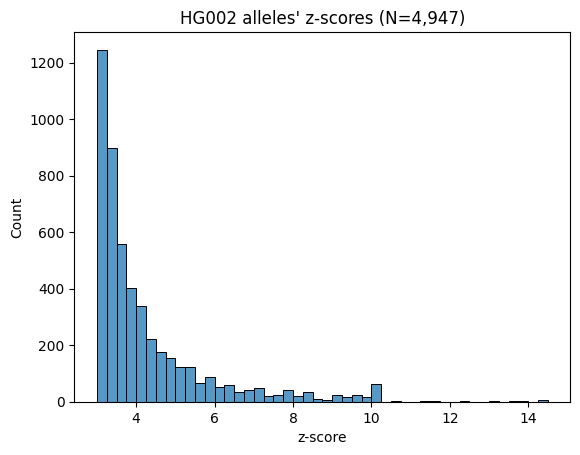

In [73]:
import seaborn as sb

interesting_loci = interesting_loci.copy() # Copying so that this frame slice can have new columns added
interesting_loci["z-score"] = (interesting_loci["allele_length"] - interesting_loci["mean"]) / interesting_loci["std"]

p = sb.histplot(data=interesting_loci, x="z-score", binwidth=0.25)
_ = p.set(title=f"{proband_name} alleles' z-scores (N={len(interesting_loci):,})")

The above example worked on a TRGTdb where the sample of interest was already merged in. If the reference samples are in a different database from the sample of interest, there's two possible workflows:
1. Including the sample while building the `length_distribution`
2. Excluding the sample while building the `length_distribution`

Workflow 1 is simple. All we need to do is consolidate the sample of interest into a `merged_database`, and then rerun the steps above.

In [ ]:
proband = trgt.load_tdb("../test_files/databases/son.tdb/")
# Note that this creates the database in-memory. Therefore, no `.tdb` files are altered
merged_database = trgt.tdb_consolidate(hprc, proband)

Workflow 2 is slightly more complex. You could create a `merged_database` and rerun the steps above after modifying the `length_distribution` calculation to exclude the sample of interest before performing the `.groupby`.

In [ ]:
length_distribution = (observed_allele_lengths
                           [observed_allele_lengths["sample_name"] != proband_name]
                           .groupby(["LocusID"])["allele_length"]
                           .describe()[["mean", "std"]])
length_distribution['upper_threshold'] = length_distribution['mean'] + length_distribution['std'] * 3

Alternatively, if you've saved the precomputed `length_distribution` with per-locus identifying information (i.e. chrom,start,end), you can do the following steps:
1. Load the `length_distribution`
2. Set its index to the chromosome, start, and end
3. Run `get_observed_allele_lengths` on the proband sample's TRGTdb.
4. Create an index on the proband's `observed_lengths` by joining to the proband's locus columns
5. Join the proband's `observed_length` to the precomputed `length_distribution`